In [1]:
!apt-get install x11-utils > /dev/null 2>&1 
!pip install pyglet > /dev/null 2>&1 
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1


In [2]:
!pip3 install box2d-py

In [3]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay


In [4]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

In [5]:
import gym
import numpy as np
from copy import deepcopy


class LunarLanderMPPI():
    """This is an implementation of the MPPI Controller (as per the paper)
    extending the controller to a LunarLander
    terminology in this code is from: https://www.youtube.com/watch?v=19QLyMuQ_BE&ab_channel=NeuromorphicWorkshopTelluride
    """

    def __init__(self, env, n, K, T, U, uinit=3, lambda_=1, noise_mu=0, noise_sigma=1):
        # do some initialization here
        self.n = n
        self.K = K
        self.T = T
        self.U = U
        self.uinit = uinit
        self.noise_mu = noise_mu
        self.noise_sigma = noise_sigma
        self.noise = np.random.normal(loc=self.noise_mu, scale=self.noise_sigma,
                                      size=(self.K, self.T))
        self.lambda_ = lambda_
        self.env = env
        self.env.reset()
        self.S = np.zeros(shape=self.K)
        self.beta = 0
        self.eta = 0
        self.omega = 0
        self.last_reward = 0

    def simulate_rollouts(self, k, copy_env):
        # self.env.env.state = self.x_init
        for t in range(0, self.T):
            rollout_action_t = int(self.U[t] + self.noise[k, t])
            if rollout_action_t<0 or rollout_action_t>3:
              continue
            _, reward, _, _ = copy_env.step(rollout_action_t)
            # copy_env.render()
            self.S[k] = self.S[k] - reward
        # copy_env.close()

    def calcBeta(self):
        self.beta = np.min(self.S)

    def calcEta(self):
        self.eta = np.sum(np.exp((-1.0 / self.lambda_) * (self.S - self.beta)))

    def calcOmega(self):
        self.omega = (1.0 / self.eta) * (np.exp((-1.0 / self.lambda_) * (self.S - self.beta)))

    def control(self):
        for _ in range(0, self.n):
            # simulation loop
            for k in range(0, self.K):
                temp = deepcopy(self.env)
                self.simulate_rollouts(k, temp)

            # from the above sampled random trajectories of control calculate the best traj
            self.calcBeta()
            self.calcEta()
            self.calcOmega()
            
            self.U[:] += [ int(np.sum(self.omega * self.noise[:, t])) for t in range(self.T)]
            np.clip(self.U, 0, 3)
            
            _, r, _, _ = self.env.step(int(self.U[0]))
            
            self.last_reward += r
            
            print("action taken: " + str(int(self.U[0])) + " reward received: " + str(r))
            
            screen = env.render(mode='rgb_array')
            plt.imshow(screen)
            ipythondisplay.clear_output(wait=True)
            ipythondisplay.display(plt.gcf())

            self.U = np.roll(self.U, -1)  # shift all elements to the left
            self.U[-1] = self.uinit
            self.S[:] = 0

            if abs(self.last_reward - r) < 0.000015:
                self.last_reward = r
                self.env.reset()
            elif r == -100:
                self.last_reward = 0
                self.env.reset()


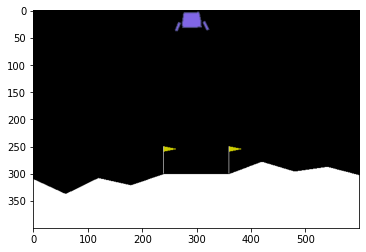

In [ ]:
# ENV_NAME = "BipedalWalker-v3"
ENV_NAME = "LunarLander-v2"

# TIMESTEPS = 20  # T
# N_SAMPLES = 1000  # K

TIMESTEPS = 2  # T
N_SAMPLES = 50  # K

ACTION_LOW = 0
ACTION_HIGH = 3

noise_mu = 0
noise_sigma = 1
lambda_ = 1
iter = 1000

env = gym.make(ENV_NAME)
# env = gym.make("BipedalWalker-v3")
U = np.random.randint(low=ACTION_LOW, high=ACTION_HIGH, size=TIMESTEPS)

lunar_mppi_gym = LunarLanderMPPI(env=env, n=iter, K=N_SAMPLES, T=TIMESTEPS, U=U, lambda_=lambda_, noise_mu=noise_mu,
                                noise_sigma=noise_sigma, uinit=0)
lunar_mppi_gym.control()